In [1]:
import torch
import json
from torchvision import transforms
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter

from data.ImageNetV2.superclassing_dataset import SuperclassImageNetV2Dataset

SUPERCLASS_DATASET_PATH="./data/ImageNetV2/raw/"
IMAGENET_CLASS_INDEX_PATH = "./data/ImageNetV2/imagenet_class_index.json"
SUPER_CLASS_INDEX_PATH = "./data/ImageNetV2/superclass/superclass_index.json"

mode = {
    "tick": 17,
    "fig": [5, 4],
    "legend": 13,
    "label": 14
}

marker_list = [
    ".",
    "o",
    "v",
    "8",
    "s",
    "p",
    "P",
    "*",
    "x",
    4,
    5,
    6,
    7,
    8,
    None,
    None
]

superclass_names = [
    "Bird",
    "Boat",
    "Car",
    "Cat",
    "Dog",
    "Fruit",
    "Fungus",
    "Insect",
    "Monkey"
]

## load ImageNet V2

In [2]:
with open(IMAGENET_CLASS_INDEX_PATH, 'r') as f:
    imagenet_class_index = json.load(f)

idx_to_class_desc = {}
for key, value in imagenet_class_index.items():
        label = int(key)
        class_desc = value[1]
        if " " in class_desc:
            class_desc = class_desc.replace(" ", "_")
        idx_to_class_desc[label] = class_desc

In [3]:
with open(SUPER_CLASS_INDEX_PATH, 'r') as f:
    label_to_superclass=json.load(f)

len(label_to_superclass)

329

In [4]:
superclass_label_count = {}

for label, superclass_idx in label_to_superclass.items():
    if superclass_idx not in superclass_label_count:
        superclass_label_count[superclass_idx] = 0
    superclass_label_count[superclass_idx] += 1

superclass_label_count_named = {superclass_names[idx]: count for idx, count in superclass_label_count.items()}
superclass_label_count_named

{'Bird': 64,
 'Insect': 42,
 'Dog': 130,
 'Cat': 9,
 'Fruit': 22,
 'Monkey': 21,
 'Car': 13,
 'Boat': 16,
 'Fungus': 12}

In [6]:
superclass_label_count

{0: 64, 7: 42, 4: 130, 3: 9, 5: 22, 8: 21, 2: 13, 1: 16, 6: 12}

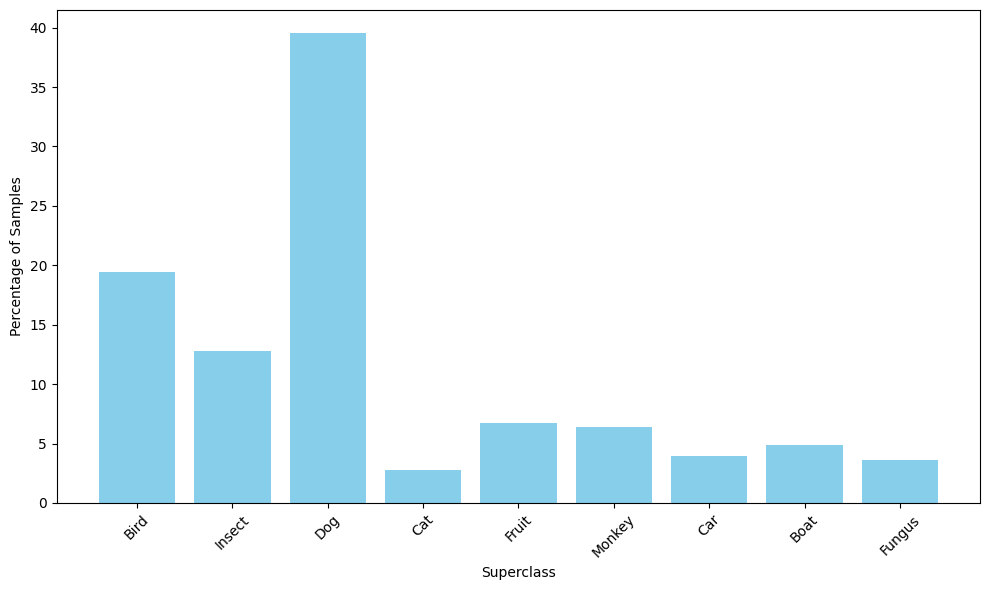

Imbalance Ratio: 14.44
The dataset is significantly imbalanced. Training separate models for each superclass can help:
- Focus on specific features relevant to each superclass.
- Mitigate the impact of class imbalance on model performance.
- Allow for specialized data augmentation and preprocessing techniques.


In [7]:
total_samples = sum(superclass_label_count_named.values())

# Calculate percentage of samples in each superclass
superclass_percentage = {k: (v / total_samples) * 100 for k, v in superclass_label_count_named.items()}

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(superclass_percentage.keys(), superclass_percentage.values(), color='skyblue')
plt.xlabel('Superclass')
plt.ylabel('Percentage of Samples')
# plt.title('Class Distribution in Superclass ImageNet V2 Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate imbalance ratio
max_samples = max(superclass_label_count_named.values())
min_samples = min(superclass_label_count_named.values())
imbalance_ratio = max_samples / min_samples

print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

# Justification for separate models
if imbalance_ratio > 2:  # Arbitrary threshold for significant imbalance
    print("The dataset is significantly imbalanced. Training separate models for each superclass can help:")
    print("- Focus on specific features relevant to each superclass.")
    print("- Mitigate the impact of class imbalance on model performance.")
    print("- Allow for specialized data augmentation and preprocessing techniques.")
else:
    print("The dataset is relatively balanced. A single model might suffice.")

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

custom_dataset = SuperclassImageNetV2Dataset(transform=transform, root=SUPERCLASS_DATASET_PATH, superclass_index_path=SUPER_CLASS_INDEX_PATH)
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

In [7]:
len(custom_dataset)

3290

In [13]:
for images, labels, superclass in dataloader:
    print(len(images), labels, superclass)
    break

32 tensor([135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 307, 307, 307, 307,
        307, 307, 307, 307, 307, 307,  95,  95,  95,  95,  95,  95,  95,  95,
         95,  95, 300, 300]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 7, 7])


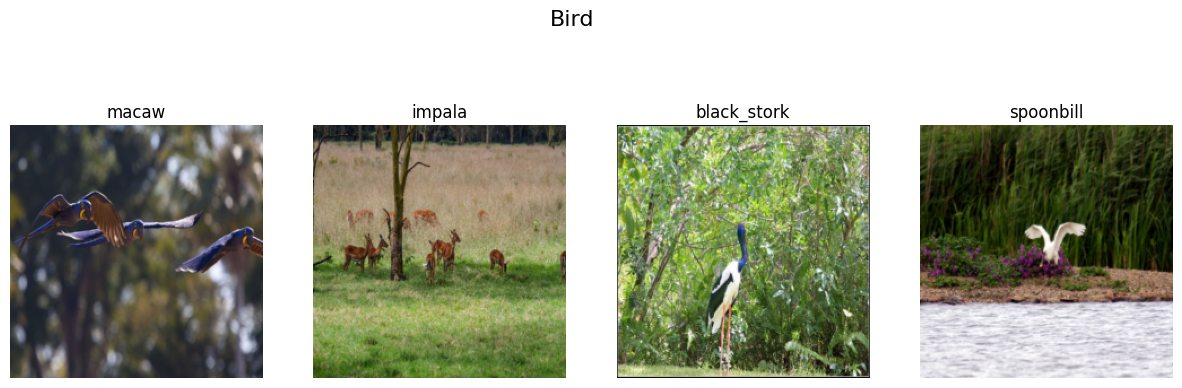

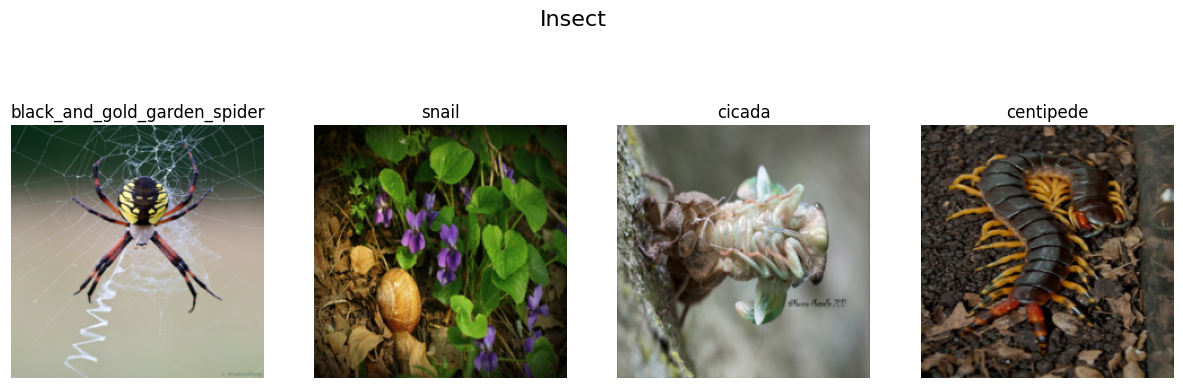

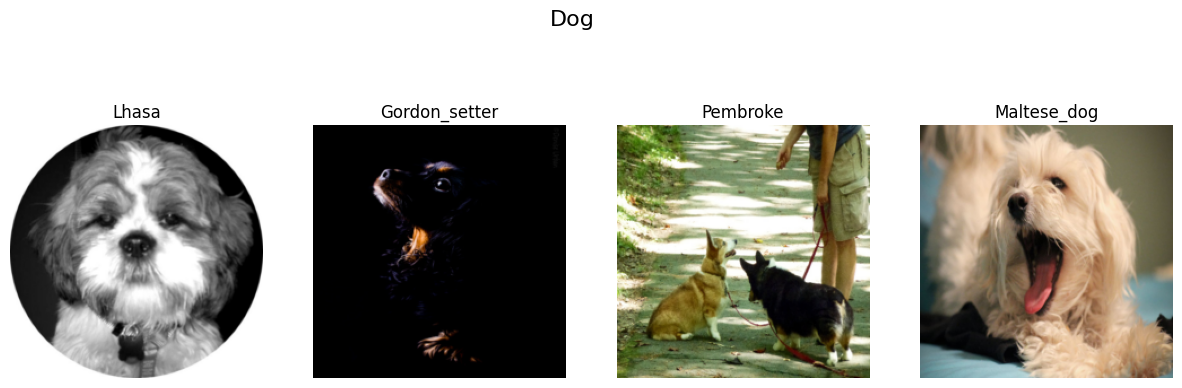

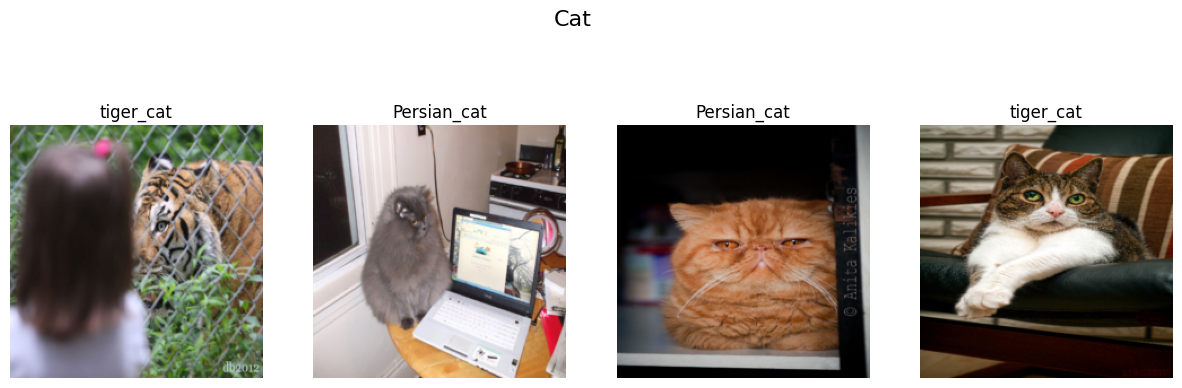

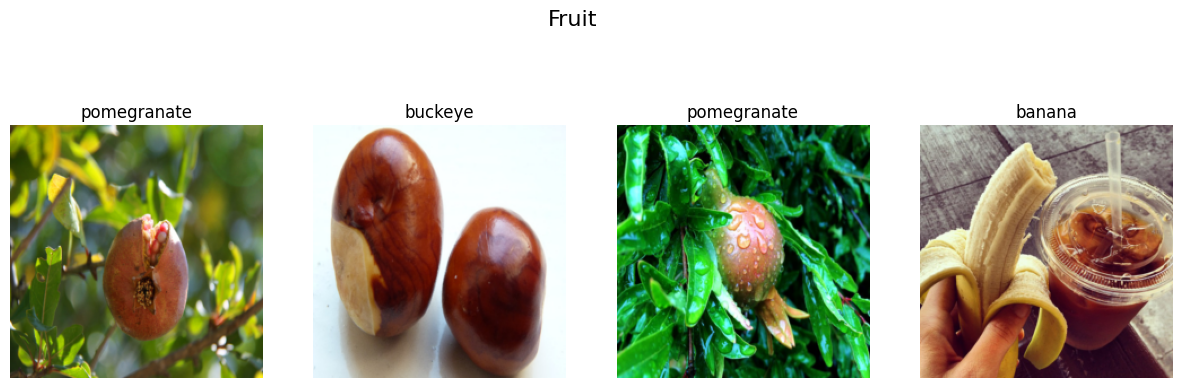

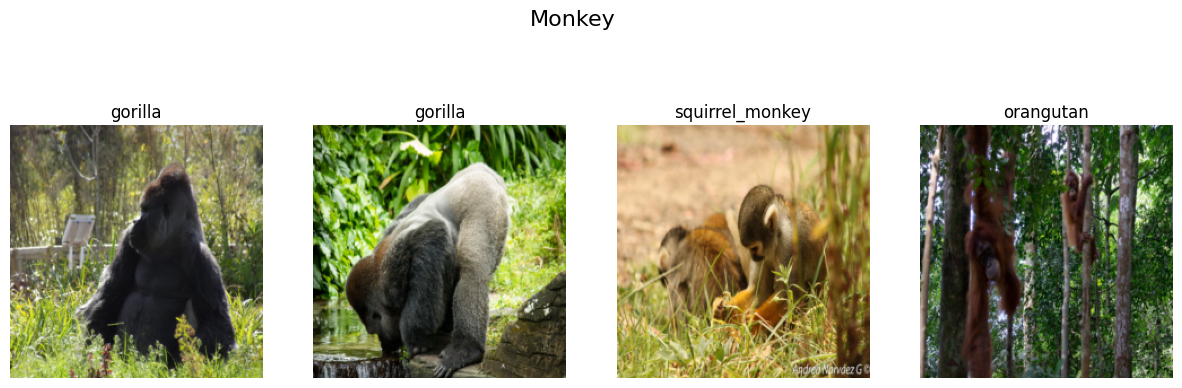

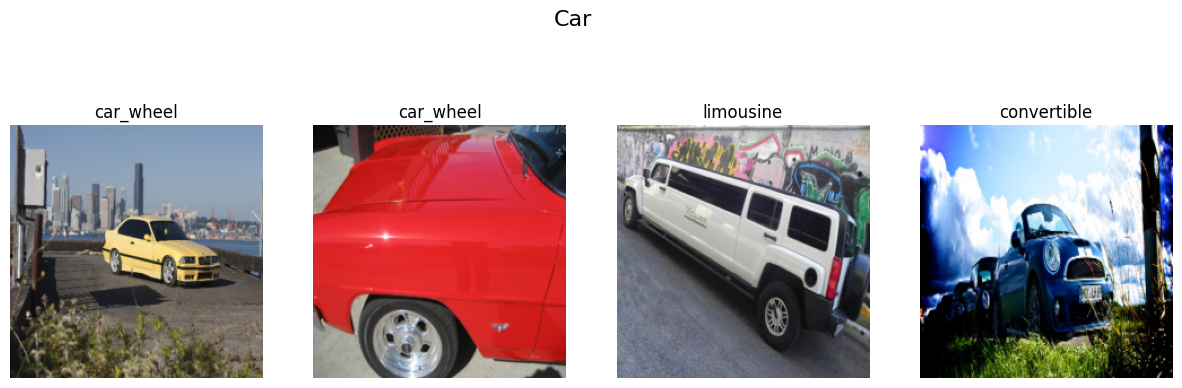

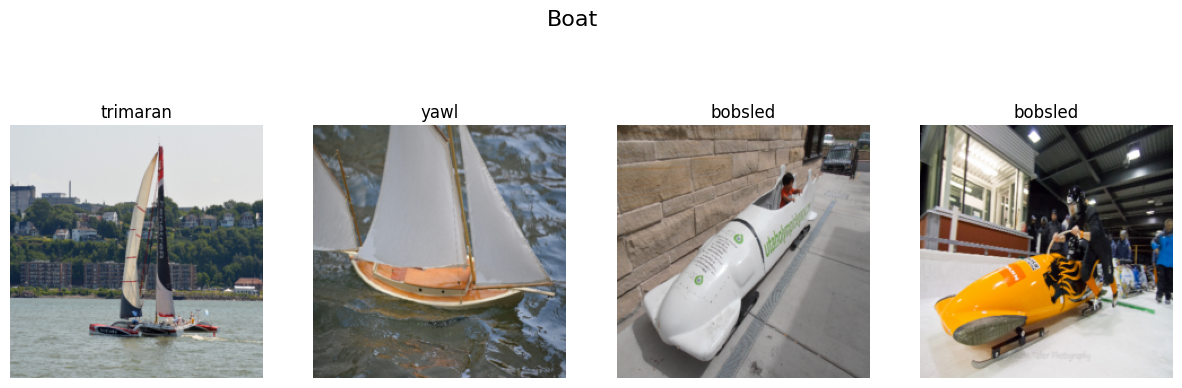

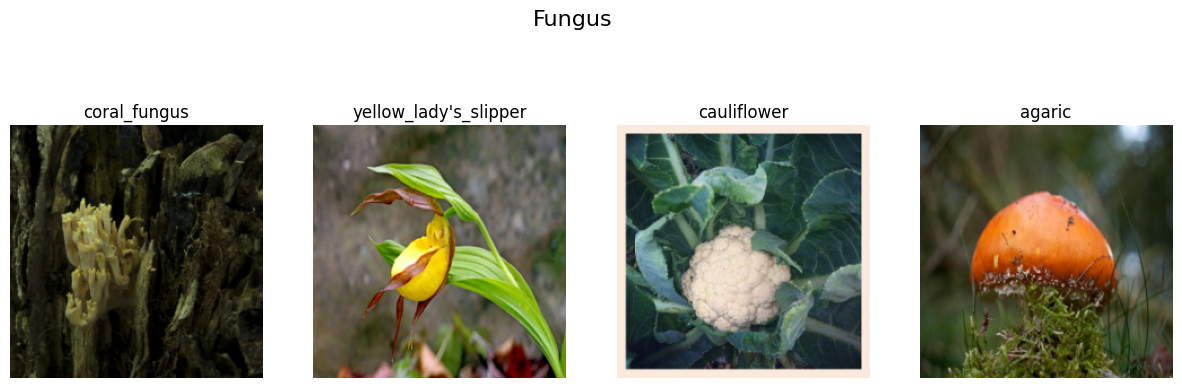

In [8]:
def display_images(images, labels, class_names, superclass):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(superclass_names[superclass], fontsize=16)
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(ToPILImage()(img))
        # Use the label itself as a fallback if not found in class_names
        ax.set_title(class_names.get(label, f"Label: {label}"))
        ax.axis('off')
    plt.show()

for superclass, count in superclass_label_count.items():
    images_to_display = []
    labels_to_display = []
    
    for images, labels, superclass_indices in dataloader:
        for img, label, super_label in zip(images, labels, superclass_indices):
            if super_label == superclass:
                images_to_display.append(img)
                labels_to_display.append(label.item())
                if len(images_to_display) == 4:
                    break
        if len(images_to_display) == 4:
            break
    
    display_images(images_to_display, labels_to_display, idx_to_class_desc, superclass)